# Aux 2
## AS4501-1 Astroinformatics

Profs: Valentino Gonzalez, Francisco Forster.

T.A: Melissa Fuentealba.

# Contents

- Linear Regression
- Cross-Validation
- Lasso Regression
- Ridge Regression
- Huber Loss Regression


# Example

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
plt.rcParams["figure.figsize"] = (10,7)

df = pd.read_csv("Example.txt", delimiter = " ")
df.head(), len(df)

(          x         y     err_y
 0  1.829061  3.870007  0.274090
 1  2.108167  3.834303  0.101183
 2  1.996398  3.785603  0.485336
 3  2.342454  4.080700  0.128582
 4  0.333504 -0.035431  0.135968,
 50)

In [3]:
x = df['x']
y = df['y']
err_y = df['err_y']

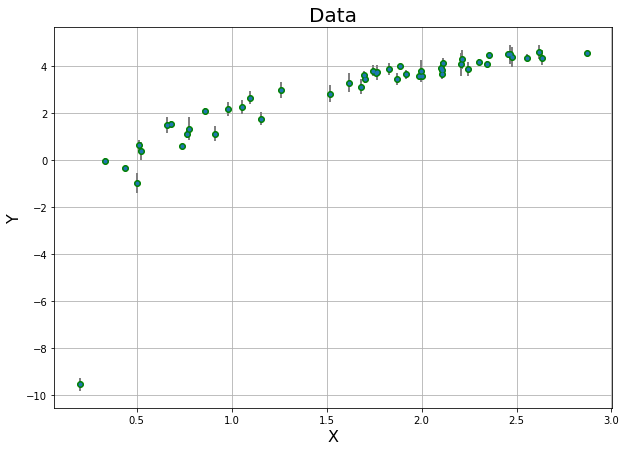

In [4]:
plt.plot(x, y, 'go')
plt.errorbar(x = x, y = y, yerr =err_y , fmt = '.', ecolor = 'gray', lw=2)
plt.title("Data", size=20)
plt.xlabel("X", size=16)
plt.ylabel("Y", size=16)
plt.grid()
plt.show()

### Split the data

- sklearn https://scikit-learn.org/stable/supervised_learning.html#supervised-learning
- train_test_split: Split arrays or matrices into $\textbf{random}$ train and test subsets.

In [178]:
from sklearn.model_selection import train_test_split

np.random.seed(90) 
train, test = train_test_split(df)

# Train set
train_x = train.x.values.reshape(-1,1)
train_y = train.y.values.reshape(-1,1)

# Test set
test_x = test.x.values.reshape(-1,1)
test_y = test.y.values.reshape(-1,1)

In [179]:
np.shape(train.x.values), np.shape(train_x)

((37,), (37, 1))

In [180]:
train.x.values[0:5]

array([0.49899205, 1.26185835, 1.09782589, 1.98667053, 1.99639773])

In [181]:
train_x[0:5]

array([[0.49899205],
       [1.26185835],
       [1.09782589],
       [1.98667053],
       [1.99639773]])

# Linear Regression

In [182]:
from sklearn import linear_model

# Create linear regression object
lin = linear_model.LinearRegression()

# Train the model using the training sets
lin.fit(train_x, train_y)

LinearRegression()

- linear_model: includes a set of methods intended for regression in which the target value is expected to be a linear combination of the features.

- LinearRegression: fits a linear model with coefficients to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation. 

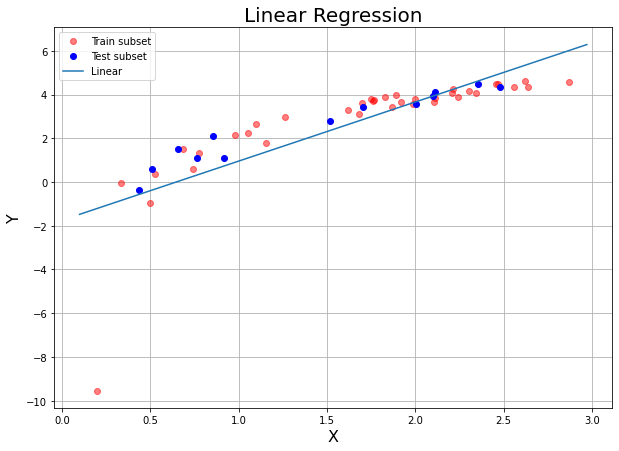

In [183]:
plt.plot(train.x, train.y, 'ro', alpha=0.5, label = 'Train subset')
plt.plot(test.x, test.y, 'bo', label = 'Test subset')

x_to_plot = np.linspace(min(x) - 0.1, max(x) + 0.1, 100)

# Make predictions of our model
plt.plot(x_to_plot, lin.predict(x_to_plot.reshape(-1,1)), label='Linear')

plt.xlabel("X", size=16)
plt.ylabel("Y", size=16)
plt.title('Linear Regression', size=20)
plt.grid()
plt.legend()
plt.show()

# Polynomial Regression

- A simple linear regression can be extended by constructing polynomial features from the coefficients using PolynomialFeatures.

-  A single object representing a simple polynomial regression can be created using Pipeline.

In [184]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

degrees = np.arange(1, 11, 1)
rms_train = []
rms_test = []
coefs = []
for deg in degrees:
    
    # Polynomial model
    model = Pipeline([('poly', PolynomialFeatures(degree=deg)),
                  ('linear', linear_model.LinearRegression())])
    
    # Train the model using the training sets
    model = model.fit(train_x, train_y)
    
    # The polynomial coefficients
    coefs.append(model.named_steps['linear'].coef_)
    
    # Mean Squared Error (MSE) 
    rmstrain = mean_squared_error(train_y, model.predict(train_x))
    rmstest = mean_squared_error(test_y, model.predict(test_x))

    rms_train.append(rmstrain)
    rms_test.append(rmstest)

In [185]:
coefs[0], coefs[1], coefs[2], coefs[3]

(array([[0.        , 2.70352827]]),
 array([[ 0.        ,  8.59877768, -1.94593904]]),
 array([[  0.        ,  21.31756058, -11.44273403,   2.03263841]]),
 array([[  0.        ,  40.42549981, -36.55998481,  14.37235844,
          -2.02052138]]))

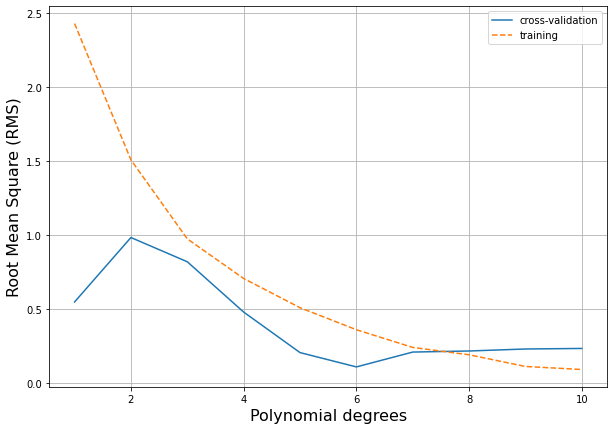

In [186]:
plt.plot(degrees, rms_test, label = "cross-validation")
plt.plot(degrees, rms_train, "--", label = "training")
plt.grid()
plt.xlabel("Polynomial degrees", size=16)
plt.ylabel("Root Mean Square (RMS)", size=16)
plt.legend(loc=0)
plt.show()

We observe that the training set is behaving as we expect, decreasing with polynomial of higher order because the predicted points are compared with the same data used to fit them. The optimal degree is in which the cross-validation reaches its minimum.

In [205]:
degree_cv = 6

In [206]:
model = Pipeline([('poly', PolynomialFeatures(degree=degree_cv)),
                  ('linear', linear_model.LinearRegression())])
model = model.fit(train_x, train_y)
model.named_steps['linear'].coef_

array([[   0.        ,  138.87329711, -265.74025958,  256.08097032,
        -129.66858115,   32.94527566,   -3.30890213]])

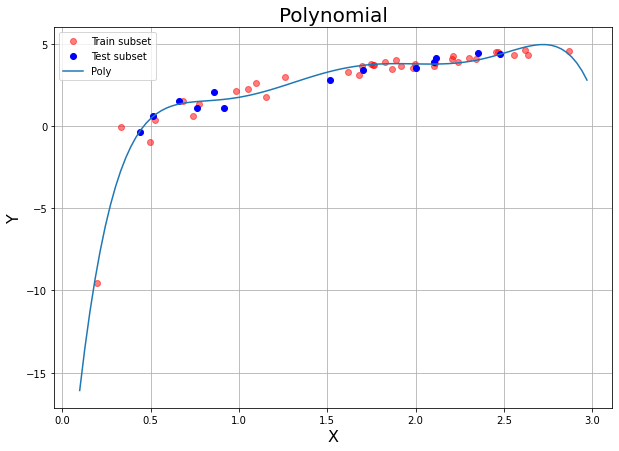

In [207]:
plt.plot(train.x, train.y, 'ro', alpha=0.5, label = 'Train subset')
plt.plot(test.x, test.y, 'bo', label = 'Test subset')

x_to_plot = np.linspace(min(x) - 0.1, max(x) + 0.1, 100)
plt.plot(x_to_plot, model.predict(x_to_plot.reshape(-1,1)), label='Poly')
plt.xlabel("X", size=16)
plt.ylabel("Y", size=16)
plt.title('Polynomial', size=20)
plt.grid()
plt.legend()
plt.show()

### Interpretation

- A simple polynomial method does not penalize the outliers and tries to fit the model to all the points.

# Ridge Regression

Ridge regression addresses some of the problems of Ordinary Least Squares by imposing a penalty on the size of the coefficients with $\textbf{L2}$
regularization.

- The $\alpha$ parameter controls the degree of sparsity of the estimated coefficients.

In [208]:
ridge = Pipeline([('poly', PolynomialFeatures(degree=degree_cv)),
                       ('linear', linear_model.Ridge(alpha=0.5))])
ridge = ridge.fit(train_x, train_y)
# Let's see the coefficients of our model
ridge.named_steps['linear'].coef_

array([[ 0.        ,  4.14452544,  2.06032355, -0.35027292, -1.22474213,
         0.54119296, -0.06150858]])

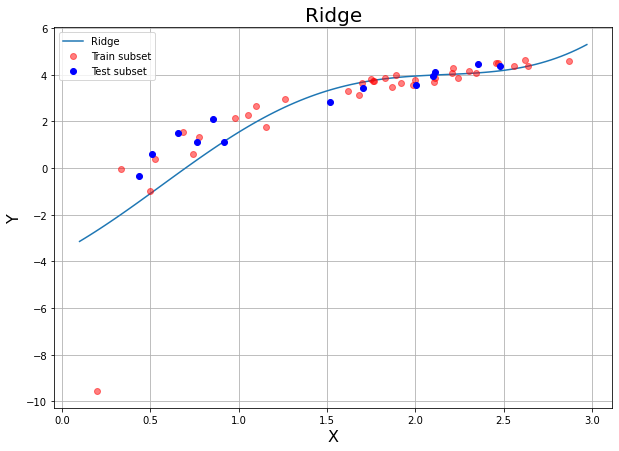

In [209]:
plt.plot(x_to_plot, ridge.predict(x_to_plot.reshape(-1,1)), label='Ridge')
plt.plot(train.x, train.y, 'ro', alpha=0.5, label = 'Train subset')
plt.plot(test.x, test.y, 'bo', label = 'Test subset')
plt.xlabel("X", size=16)
plt.ylabel("Y", size=16)
plt.grid()
plt.title('Ridge', size=20)
plt.legend()
plt.show()

### Setting the regularization parameter

RidgeCV implements ridge regression with built-in cross-validation of the alpha parameter. 

In [210]:
from sklearn import linear_model
# Definition of the ridge cv model
reg = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13))
reg.fit(train_x, train_y)

# optimal alpha
reg.alpha_

1.0

In [211]:
ridge_reg = Pipeline([('poly', PolynomialFeatures(degree=degree_cv)),
                       ('linear', linear_model.Ridge(alpha=reg.alpha_))])
ridge_reg = ridge_reg.fit(train_x, train_y)
ridge_reg.named_steps['linear'].coef_

array([[ 0.        ,  2.73416846,  1.6620718 ,  0.15981267, -0.64915493,
         0.07034172,  0.02288154]])

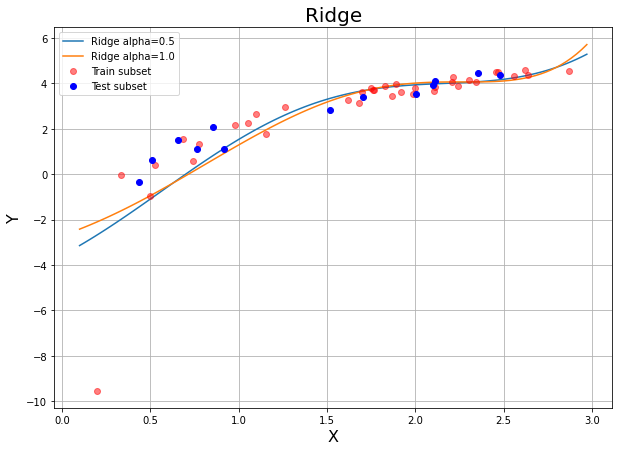

In [212]:
plt.plot(x_to_plot, ridge.predict(x_to_plot.reshape(-1,1)), label='Ridge alpha=0.5')
plt.plot(x_to_plot, ridge_reg.predict(x_to_plot.reshape(-1,1)), label='Ridge alpha='+str(reg.alpha_))
plt.plot(train.x, train.y, 'ro', alpha=0.5, label = 'Train subset')
plt.plot(test.x, test.y, 'bo', label = 'Test subset')
plt.xlabel("X", size=16)
plt.ylabel("Y", size=16)
plt.grid()
plt.title('Ridge', size=20)
plt.legend()
plt.show()

# Lasso Regression

The Lasso is a linear model that estimates sparse coefficients with $\textbf{L1}$ regularization.

L1 regularization adds a penalty equal to the absolute value of the magnitude of coefficients. This type of regularization can result in sparse models with few coefficients; Some coefficients can become zero and eliminated from the model.

In [213]:
lasso = Pipeline([('poly', PolynomialFeatures(degree=degree_cv)),
                       ('linear', linear_model.Lasso(alpha=0.5))])
lasso = lasso.fit(train_x, train_y)
lasso.named_steps['linear'].coef_

array([ 0.        ,  0.        ,  0.        ,  0.53643594,  0.        ,
        0.        , -0.01655118])

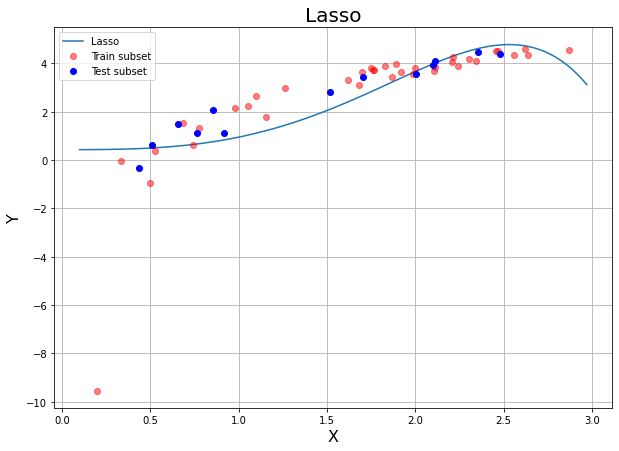

In [214]:
plt.plot(x_to_plot, lasso.predict(x_to_plot.reshape(-1,1)), label='Lasso')
plt.plot(train.x, train.y, 'ro', alpha=0.5, label = 'Train subset')
plt.plot(test.x, test.y, 'bo', label = 'Test subset')
plt.xlabel("X", size=16)
plt.ylabel("Y", size=16)
plt.grid()
plt.title('Lasso', size=20)
plt.legend()
plt.show()

### Interpretation

Lasso is not fitting the observations as well as expected as it penalized the coefficients of the polynomial with L1 regularization, turning most of the coefficients into zero as Lasso consideres them less important, then the model was too simple for the data.


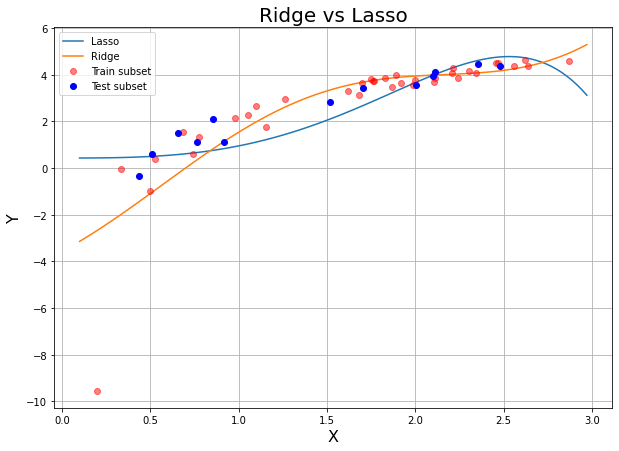

In [215]:
plt.plot(x_to_plot, lasso.predict(x_to_plot.reshape(-1,1)), label='Lasso')
plt.plot(x_to_plot, ridge.predict(x_to_plot.reshape(-1,1)), label='Ridge')
plt.plot(train.x, train.y, 'ro', alpha=0.5, label = 'Train subset')
plt.plot(test.x, test.y, 'bo', label = 'Test subset')
plt.xlabel("X", size=16)
plt.ylabel("Y", size=16)
plt.grid()
plt.title('Ridge vs Lasso', size=20)
plt.legend()
plt.show()

# Huber Loss Regression

- HuberRegressor is different to Ridge because it applies a linear loss to samples that are classified as outliers. A sample is classified as an inlier if the absolute error of that sample is lesser than a certain threshold.

- epsilon ($\epsilon$) parameter is the threshold. It is advised to set the parameter epsilon to 1.35 to achieve 95% statistical efficiency.

- alpha ($\alpha$) has been left as default = 0.001.

- ravel will convert that array shape to (n, ) (to flatten it)

- max_iter=100 is the default, in this case it was not enough so we set the parameter to a higher value.

In [218]:
from sklearn.linear_model import HuberRegressor

huber = Pipeline([('poly', PolynomialFeatures(degree=degree_cv)),
                       ('linear', linear_model.HuberRegressor(epsilon=1.35, max_iter=100))])
huber = huber.fit(train_x, train_y.ravel())
huber.named_steps['linear'].coef_

array([-1.17001158,  3.59490024,  2.506534  , -0.48896189, -2.1190108 ,
        1.20505541, -0.1850717 ])

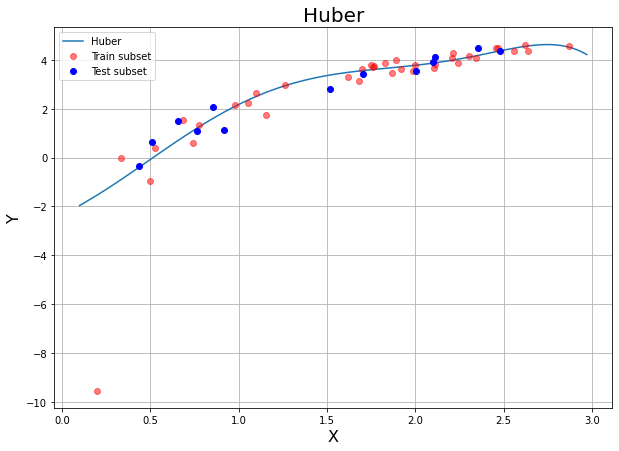

In [217]:
plt.plot(x_to_plot, huber.predict(x_to_plot.reshape(-1,1)), label='Huber')
plt.plot(train.x, train.y, 'ro', alpha=0.5, label = 'Train subset')
plt.plot(test.x, test.y, 'bo', label = 'Test subset')
plt.grid()
plt.xlabel("X", size=16)
plt.ylabel("Y", size=16)
plt.title('Huber', size=20)
plt.legend()
plt.show()

### Interpretation

- Huber ignores the outliers pretty well and is modelling the distribution of the data very smoothly.

# Ridge, Lasso and Huber Loss

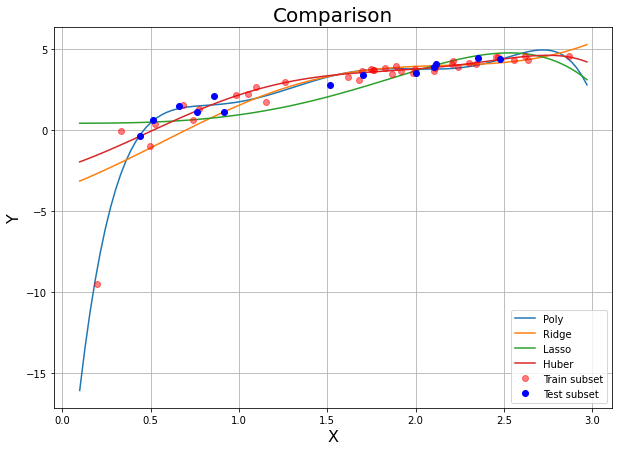

In [203]:
plt.plot(x_to_plot, model.predict(x_to_plot.reshape(-1,1)), label='Poly')
plt.plot(x_to_plot, ridge.predict(x_to_plot.reshape(-1,1)), label='Ridge')
plt.plot(x_to_plot, lasso.predict(x_to_plot.reshape(-1,1)), label='Lasso')
plt.plot(x_to_plot, huber.predict(x_to_plot.reshape(-1,1)), label='Huber')
plt.plot(train.x, train.y, 'ro', alpha=0.5, label = 'Train subset')
plt.plot(test.x, test.y, 'bo', label = 'Test subset')
plt.xlabel("X", size=16)
plt.ylabel("Y", size=16)
plt.grid()
plt.title('Comparison', size=20)
plt.legend()
plt.show()

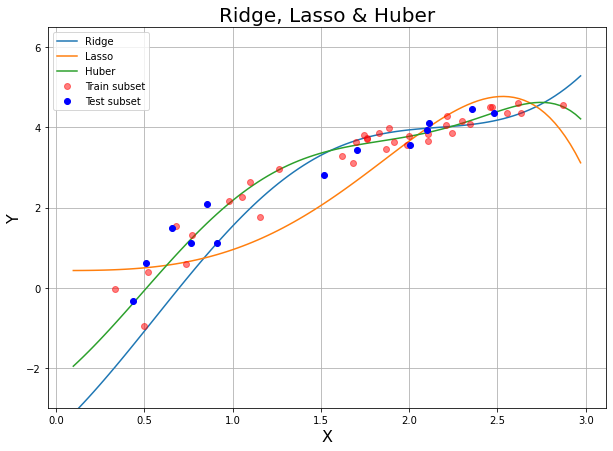

In [204]:
plt.plot(x_to_plot, ridge.predict(x_to_plot.reshape(-1,1)), label='Ridge')
plt.plot(x_to_plot, lasso.predict(x_to_plot.reshape(-1,1)), label='Lasso')
plt.plot(x_to_plot, huber.predict(x_to_plot.reshape(-1,1)), label='Huber')
plt.plot(train.x, train.y, 'ro', alpha=0.5, label = 'Train subset')
plt.plot(test.x, test.y, 'bo', label = 'Test subset')
plt.xlabel("X", size=16)
plt.ylabel("Y", size=16)
plt.grid()
plt.ylim(-3,6.5)
plt.title('Ridge, Lasso & Huber', size=20)
plt.legend()
plt.show()